# A/B test case study for pricing data

- Random split of users into different groups of different pricing setups and configurations to determine which setup performs best.
- In this case, the test group and control group are exposed to similar variables/external factors vs. the control -> keeping all other variables identical (ideally) to perform a A/B test for pricing variable.

## Goal of the hypothesis testing

- Perform pricing tedst to determine the right delivery fee setup to **achieve the same revenue but with More orders**.

**Revenue**
$r = v * c (25$%$) + f$

i.e. \
Revenue = r \
order value = v\
commission = c\
delivery fee = f \

**KPIs measurement**
- orders
- average order value (total order value / total orders)
- delivery fee
- revenue

**DOE test scheme**

1. Control group: delivery fee flat at \\$2.29 for all orders, regardless of order value.
2. Test group: Over \\$45 -> free delivery, Less than \\$45 -> \\$2.69 delivery fee.

**Hypothesis**

H0: there is no difference in each of KPIs above between the control and test group.
H1. There are differences in each of KPIs above between the control and test group.

**Methodology** \
[Wilcoxon Rank signed test](https://en.wikipedia.org/wiki/Wilcoxon_signed-rank_test#:~:text=The%20Wilcoxon%20signed%2Drank%20test,is%20a%20paired%20difference%20test)

## 1. Import libs

In [121]:
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Import dataset

In [168]:
# The code was removed by Watson Studio for sharing.

SyntaxError: invalid syntax (701326460.py, line 3)

In [75]:
df.head(5)

,date,code,variant_transaction,order_value,hour,delivery_fee,revenue
0,7/1/2021,1,Control,10.0,21,2.29,4.29
1,7/1/2021,2,Control,12.0,21,2.29,4.69
2,7/1/2021,3,Control,17.0,10,2.29,5.69
3,7/1/2021,4,Control,24.0,13,2.29,7.09
4,7/1/2021,5,Control,36.0,17,2.29,9.49


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18006 entries, 0 to 18005
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 18006 non-null  object 
 1   code                 18006 non-null  int64  
 2   variant_transaction  18006 non-null  object 
 3   order_value          18006 non-null  float64
 4   hour                 18006 non-null  int64  
 5   delivery_fee         18006 non-null  float64
 6   revenue              18006 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 984.8+ KB


In [77]:
# check duplication
df[df.code.duplicated()]

,date,code,variant_transaction,order_value,hour,delivery_fee,revenue


In [78]:
# convert dtypes
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))

In [79]:
df.dtypes

date                   datetime64[ns]
code                            int64
variant_transaction            object
order_value                   float64
hour                            int64
delivery_fee                  float64
revenue                       float64
dtype: object

## 3. EDA

In [83]:
# check general stats
df.describe()

,code,order_value,hour,delivery_fee,revenue
count,18006.000000,18006.000000,18006.000000,18006.000000,18006.000000
mean,9003.500000,30.722147,15.183939,2.105095,8.250083
std,5198.028809,24.004978,4.451440,0.868962,4.384279
min,1.000000,4.000000,8.000000,0.000000,3.150000
25%,4502.250000,14.700000,11.000000,2.290000,5.430000
50%,9003.500000,24.340000,16.000000,2.290000,7.330000
75%,13504.750000,38.000000,19.000000,2.490000,9.360000
max,18006.000000,260.000000,21.000000,3.290000,52.000000


In [84]:
#check null
pd.isnull(df).sum()

date                   0
code                   0
variant_transaction    0
order_value            0
hour                   0
delivery_fee           0
revenue                0
dtype: int64

In [99]:
#Group KPIs by variant transaction type
group_kpis = df.groupby(by='variant_transaction').agg({'code': pd.Series.nunique,
                                                      'order_value': sum,
                                                      'hour':'mean',
                                                      'delivery_fee':sum,
                                                      'revenue':sum}).reset_index()
group_kpis

,variant_transaction,code,order_value,hour,delivery_fee,revenue
0,Control,8232,241414.73,15.265306,18851.28,67134.0
1,Test,9774,311768.24,15.115408,19053.06,81417.0


In [119]:
#Group KPIs by daily transaction
daily_kpis = df.pivot_table(values=['code','order_value','delivery_fee','revenue'],
                            index='date',columns='variant_transaction',
                            aggfunc={'code':pd.Series.nunique,                                                      
                                     'order_value':sum,                                                      
                                     'delivery_fee':sum,                                                      
                                     'revenue':sum}).reset_index()

#reassign column names
daily_kpis.columns = map(str.lower, ['_'.join(col).strip() for col in daily_kpis.columns.values])
daily_kpis.rename(columns={'date_': 'date'}, inplace=True)
daily_kpis.head()

,date,code_control,code_test,delivery_fee_control,delivery_fee_test,order_value_control,order_value_test,revenue_control,revenue_test
0,2021-07-01,240,228,549.60,433.26,6008.06,6956.06,1749.66,1825.44
1,2021-07-02,198,264,453.42,358.56,5632.06,12702.54,1581.54,2899.26
2,2021-07-03,306,282,700.74,448.20,10069.58,9509.08,2715.36,2349.66
3,2021-07-04,246,216,563.34,403.38,7297.18,6808.96,2023.44,1767.30
4,2021-07-05,246,264,563.34,493.02,6335.60,7755.28,1830.42,2043.06


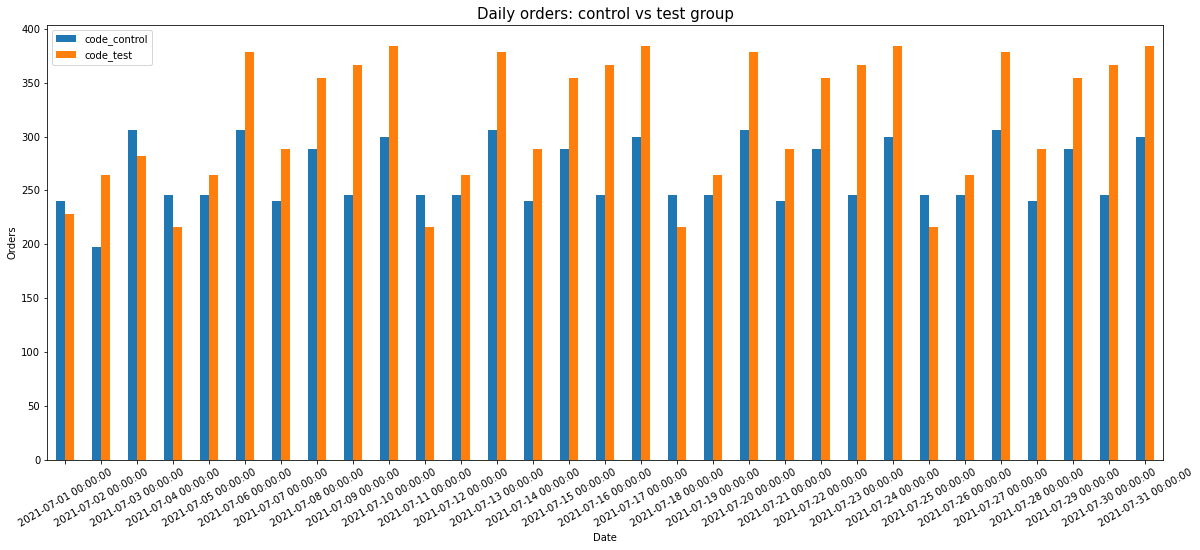

In [149]:
# Control vs. test: order instances
daily_kpis.plot(x='date',y=['code_control','code_test'],kind='bar',figsize=(20,8))
plt.xlabel("Date")
plt.ylabel("Orders")
plt.title("Daily orders: control vs test group", size = 15)
plt.xticks(rotation=30);

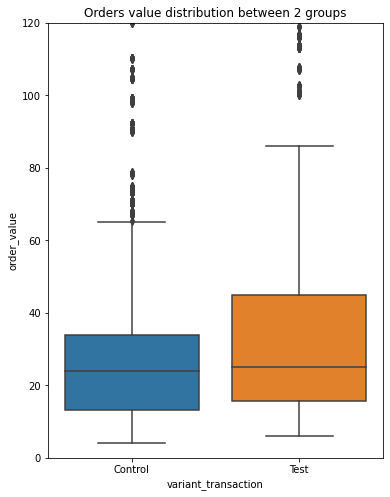

In [145]:
# IQR: Control vs. test: order value

fig, ax = plt.subplots(figsize=(6,8))
ax.set(ylim=(0,120))
sns.boxplot(x=df.variant_transaction,y=df.order_value).set_title("Orders value distribution between 2 groups");

Text(0.5, 1.0, 'Delivery free dist. Control vs. Test')

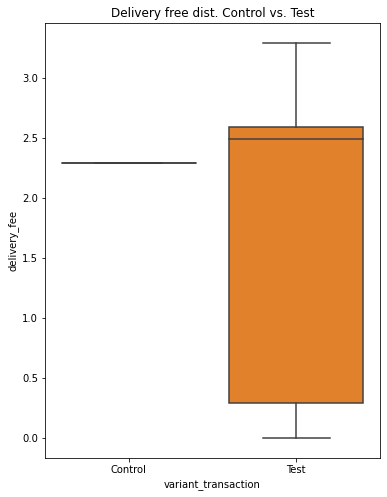

In [147]:
# IQR: control vs. test: delivery fee
fix, ax = plt.subplots(figsize = (6,8))
sns.boxplot(x=df.variant_transaction, y=df.delivery_fee).set_title('Delivery free dist. Control vs. Test')

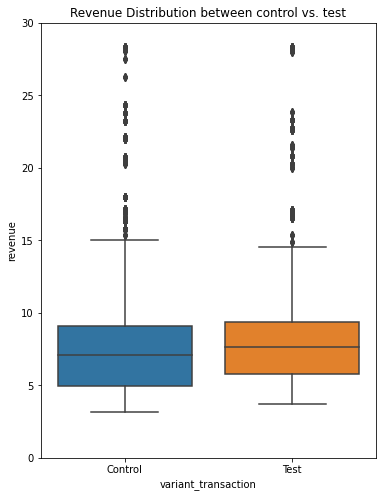

In [153]:
# IQR: control vs. test: Revenue
fig, ax = plt.subplots(figsize=(6,8))
ax.set(ylim=(0, 30))
sns.boxplot(x=df.variant_transaction,y=df.revenue).set_title("Revenue Distribution between control vs. test");

## 4. hypothesis testing

In [154]:
#Hypothesis test for #orders
order_sign = round(stats.wilcoxon(daily_kpis['code_control'], daily_kpis['code_test']) [1]/2,2)
orders = pd.DataFrame(['orders',daily_kpis['code_control'].sum(), daily_kpis['code_test'].sum(), order_sign]).T.rename(columns={
                                                                  0:'kpis',
                                                                  1: 'control_group',
                                                                  2: 'test_group',
                                                                  3: 'statistical signficant' })
orders

,kpis,control_group,test_group,statistical signficant
0,orders,8232,9774,0.0


In [156]:
# add order value per order KPI
daily_kpis['order_value_per_order_control'] = daily_kpis['order_value_control']/daily_kpis['code_control']
daily_kpis['order_value_per_order_test'] = daily_kpis['order_value_test']/daily_kpis['code_test']

In [157]:
#Hypothesis test for order values
order_value_sign = round(stats.wilcoxon(daily_kpis['order_value_per_order_control'], daily_kpis['order_value_per_order_test']) [1]/2,2)
order_value = pd.DataFrame(['order_value_per_order',daily_kpis['order_value_per_order_control'].mean(), daily_kpis['order_value_per_order_test'].mean(), order_value_sign]).T.rename(columns={
                                                                  0:'kpis',
                                                                  1: 'control_group',
                                                                  2: 'test_group',
                                                                  3: 'statistical signficant' })
order_value

,kpis,control_group,test_group,statistical signficant
0,order_value_per_order,29.179102,31.923216,0.0


In [159]:
# add delivery fee per order
daily_kpis['df_per_order_control'] = daily_kpis['delivery_fee_control']/daily_kpis['code_control']
daily_kpis['df_per_order_test'] = daily_kpis['delivery_fee_test']/daily_kpis['code_test']

In [160]:
#Hypothesis test for Delivery Fee
df_sign = round(stats.wilcoxon(daily_kpis['df_per_order_control'], daily_kpis['df_per_order_test']) [1]/2,2)
delivery_fee = pd.DataFrame(['df_per_order',daily_kpis['df_per_order_control'].mean(), daily_kpis['df_per_order_test'].mean(), df_sign]).T.rename(columns={
                                                                  0:'kpis',
                                                                  1: 'control_group',
                                                                  2: 'test_group',
                                                                  3: 'statistical signficant' })
delivery_fee

,kpis,control_group,test_group,statistical signficant
0,df_per_order,2.29,1.925049,0.0


In [162]:
# add revenue per order
daily_kpis['revenue_per_order_control'] = daily_kpis['revenue_control']/daily_kpis['code_control']
daily_kpis['revenue_per_order_test'] = daily_kpis['revenue_test']/daily_kpis['code_test']

In [163]:
#Hypothesis test for revenue
revenue_sign = round(stats.wilcoxon(daily_kpis['revenue_per_order_control'], daily_kpis['revenue_per_order_test']) [1]/2,2)
revenue = pd.DataFrame(['revenue_per_order',daily_kpis['revenue_per_order_control'].mean(), daily_kpis['revenue_per_order_test'].mean(), revenue_sign]).T.rename(columns={
                                                                  0:'kpis',
                                                                  1: 'control_group',
                                                                  2: 'test_group',
                                                                  3: 'statistical signficant' })
revenue

,kpis,control_group,test_group,statistical signficant
0,revenue_per_order,8.125863,8.310913,0.25


In [164]:
df_result = pd.concat([orders,order_value,delivery_fee,revenue])
df_result

,kpis,control_group,test_group,statistical signficant
0,orders,8232,9774,0.0
0,order_value_per_order,29.179102,31.923216,0.0
0,df_per_order,2.29,1.925049,0.0
0,revenue_per_order,8.125863,8.310913,0.25
